Gabor ML - Problem 16

-Clarice Mottet

Outline:
-generate training data
    -x_i multivariate normal distribution (mean zero, covariance diagonal (1/1...d))
    -y_i sum(x_i) + e_i where e_i standard normal random variable
-measure performance by mean squared error R(w) = E(wTX-Y)^2
-write program that learns vector w by OLS
-write program that learns vector w by GD
-write program that learns vector w by SGD
-compare performance by mean squared error and running time for multiple n and d and step size n_t

In [1]:
#libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import time

path_out_ = r'/home/clarice/Documents/VSCode/Term2_Gabor_ML/homework4/GaborML_problem16/outputs'
random.seed(123)

In [2]:
#functions

def generate_data(n, d):

    #covariance matrix
    cov = np.identity(d)    
    for i in range(d):
        cov[i,i] = 1/(i+1)

    #x
    x = np.random.multivariate_normal(np.zeros(d), cov, n)

    #y
    y = np.zeros(n)
    e = np.random.normal(0, 1, n)
    for i in range(n):
        y[i] = sum(x[i]) + e[i]

    return x, y

def solve_OLS(x, y):
    n = len(x)
    d = len(x[0])

    matrix_xx = np.zeros((d,d))
    for i in range(n):
        add_matrix = np.outer(x[i], x[i].T)
        matrix_xx = np.add(matrix_xx, add_matrix)
    matrix_xx = np.multiply(1/n, matrix_xx)
    matrix_xx = np.linalg.inv(matrix_xx)

    vec_xy = np.zeros(d)
    for i in range(n):
        add_vec = np.multiply(x[i], y[i])
        vec_xy = np.add(vec_xy, add_vec)
    vec_xy = np.multiply(1/n, vec_xy)

    w = np.dot(matrix_xx, vec_xy)
    return w

def solve_GD(x, y, step_size_type):
    """
    step_size_type have value "static" or "desc"
    """
    #initializing sizes
    n = len(x)
    d = len(x[0])
    num_epochs = n

    #step size types
    if step_size_type == "static":
        n_step = [.1 for i in range(num_epochs)]
    elif step_size_type == "desc":
        n_step = [1/np.sqrt(i+1) for i in range(num_epochs)]
    else:
        print("error with step_size_type input, 'assuming static'")
        n_step = [.1 for i in range(num_epochs)]

    #blank w matrix to hold w vector values
    w = np.zeros((num_epochs+1,d))

    #run through algorithm
    for t in range(1,num_epochs+1):
        vec_sum = np.zeros(d)
        for i in range(n):
            vec_lhs = np.multiply(np.dot(w[t-1].T,x[i]),x[i])
            vec_rhs = np.multiply(x[i], y[i])
            vec_sum = np.add(vec_sum, np.subtract(vec_lhs, vec_rhs))
        vec_sum = np.multiply(2/n,vec_sum)
        vec_sum = np.multiply(n_step[t-1],vec_sum)
        w[t] = np.subtract(w[t-1], vec_sum)

    #calculate average of weights
    w_avg = np.zeros(d)
    for t in range(1, num_epochs+1):
        w_avg = np.add(w_avg, w[t])
    w_avg = np.multiply(1/num_epochs, w_avg)
    return w_avg

#used in SGD algorithm
def shuffle_data(x, y):

    n = len(x)
    d = len(x[0])

    indexes = [i for i in range(n)]
    shuffle_index = sorted(indexes, key = lambda x: random.random())

    x_shuffle = np.zeros((n,d))
    y_shuffle = np.zeros(n)

    for i in range(n):
        x_shuffle[i] = x[shuffle_index[i]]
        y_shuffle[i] = y[shuffle_index[i]]

    return x_shuffle, y_shuffle

def solve_SGD(x_input, y_input, step_size_type):
    """
    step_size_type have value "static" or "desc"
    """

    #shuffle the data to ensure that it converges regardless of order of data points
    x, y = shuffle_data(x_input, y_input)

    #initializing sizes
    n = len(x)
    d = len(x[0])
    num_epochs = n

    #step size types
    if step_size_type == "static":
        n_step = [.1 for i in range(num_epochs)]
    elif step_size_type == "desc":
        n_step = [1/np.sqrt(i+1) for i in range(num_epochs)]
    else:
        print("error with step_size_type input, 'assuming static'")
        n_step = [.1 for i in range(num_epochs)]

    #blank w matrix to hold w vector values
    w = np.zeros((num_epochs+1,d))

    #run through algorithm
    for t in range(1,num_epochs+1):
        vec_lhs = np.multiply(np.dot(w[t-1].T,x[t-1]),x[t-1])
        vec_rhs = np.multiply(x[t-1], y[t-1])
        vec_ = np.subtract(vec_lhs, vec_rhs)
        vec_ = np.multiply(2,vec_)
        vec_ = np.multiply(n_step[t-1],vec_)
        w[t] = np.subtract(w[t-1], vec_)

    #calculate average of weights
    w_avg = np.zeros(d)
    for t in range(1, num_epochs+1):
        w_avg = np.add(w_avg, w[t])
    w_avg = np.multiply(1/num_epochs, w_avg)
    return w_avg

def calc_mse(x, y, w):
    n = len(x)
    mse = 0
    for i in range(n):
        mse += np.square(np.dot(w.T,x[i])-y[i])
    mse = mse/n
    return mse


In [5]:
#keep track of outputs
df_log = pd.DataFrame()

In [7]:
# #create a log of the simulations with various n values and d values

# n_values = [50, 100, 500, 750, 1000]
# d_values = [10, 250, 500, 1000]
# step_values = ["static", "desc"]
# method_values = ['OLS','GD','SGD']

# num_of_simulations = 10

# for iter_ in range(num_of_simulations):
#     print(iter_)
#     for n in n_values:
#         for d in d_values:
#             x_train, y_train = generate_data(n, d)
#             x_test, y_test = generate_data(n, d)
#             for step_size_type in step_values:
#                 for method in method_values:
#                     start_time = time.time()
#                     if method == 'OLS':
#                         w = solve_OLS(x_train, y_train)
#                     elif method == 'GD':
#                         w = solve_GD(x_train, y_train, step_size_type)
#                     else:
#                         w = solve_SGD(x_train, y_train, step_size_type)
#                     end_time = time.time()
#                     time_method = (end_time - start_time)
#                     mse_train = calc_mse(x_train, y_train, w)
#                     mse_test = calc_mse(x_test, y_test, w)
#                     df_ = pd.DataFrame([[iter_, method, step_size_type, n, d, time_method, mse_train, mse_test]], columns = ['simulation_run','method','step_size_type','n_value','d_value','run_time','mse_train','mse_test'])
#                     df_log = pd.concat([df_log, df_], ignore_index = True)
#                     df_log.reset_index(drop = True, inplace = True)
#                     df_log.to_excel(path_out_+'//'+'df_log_smallern.xlsx',index = False)


In [13]:
#reimport in df_log

d_values = [10, 250, 500, 1000]
df_log = pd.read_excel(path_out_+'//'+'df_log_smallern.xlsx')
#take the log of the MSE columns (once average is calculated)
#divide run time by 60 to get minutes
df_log['run_time'] = df_log['run_time']/60

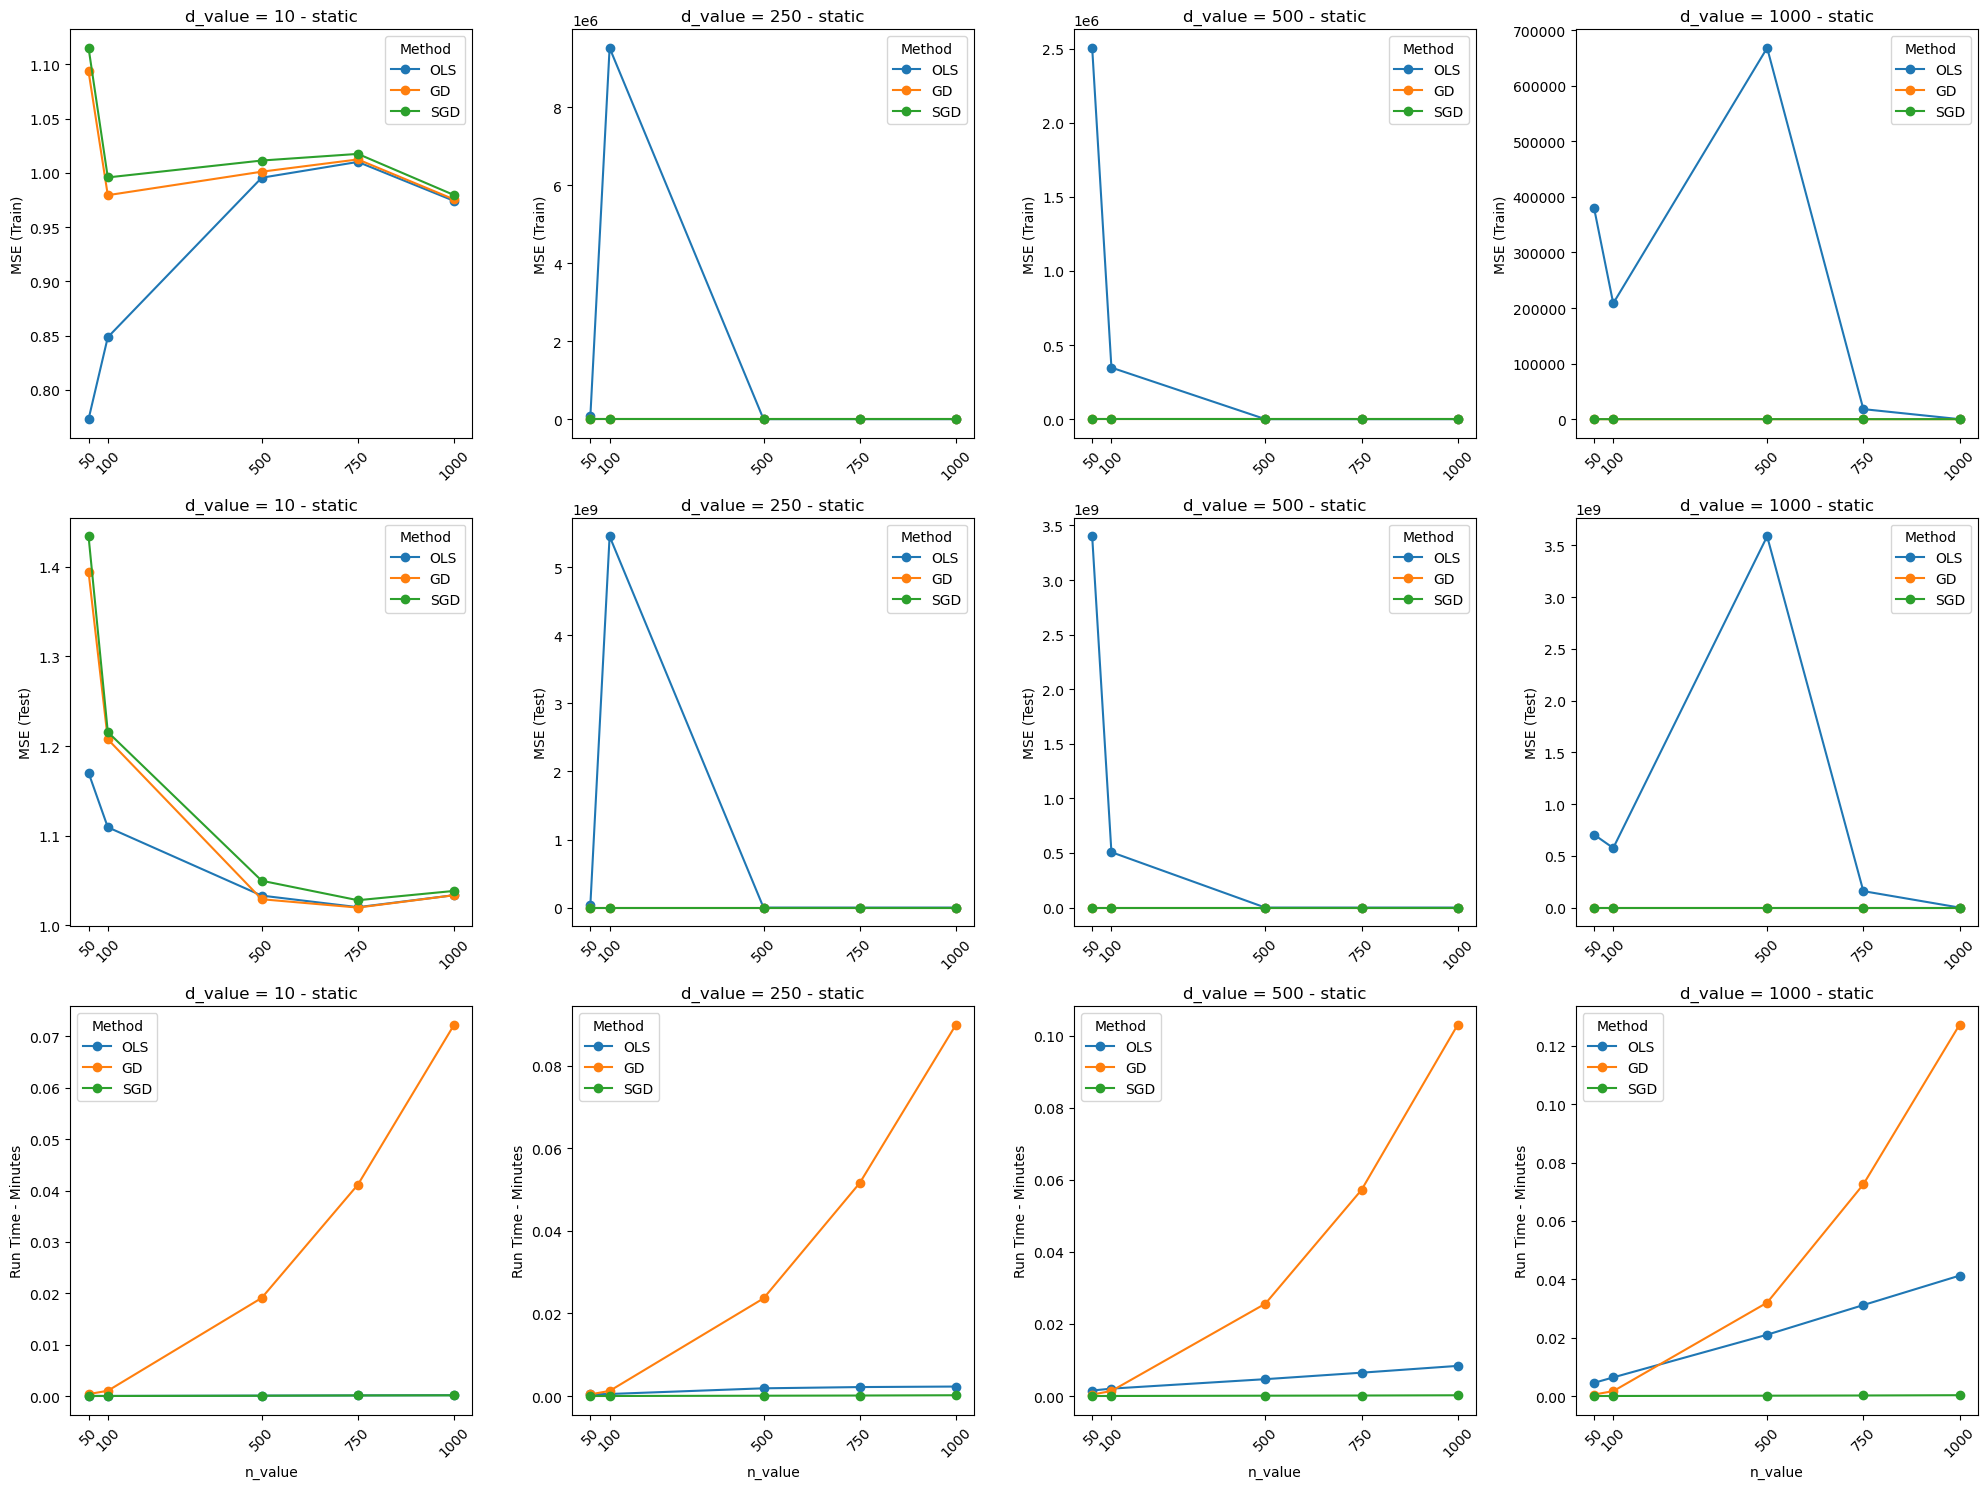

In [14]:
#plot results

step_size_type = "static"

df_log_ = df_log[df_log['step_size_type']==step_size_type].copy()
df_log_.reset_index(drop = True, inplace = True)

col_avg_values = ['mse_train','mse_test','run_time']
for col in col_avg_values:
    df_log_[col] = df_log_.groupby(by = ['method','n_value','d_value'])[col].transform('mean')

df_log_.drop_duplicates(subset = ['method','n_value','d_value'], inplace = True)
methods = ['OLS', 'GD', 'SGD']
# df_log_['mse_train'] = np.log10(df_log_['mse_train'])
# df_log_['mse_test'] = np.log10(df_log_['mse_test'])
df = df_log_.copy()

# Creating the plot with adjustments for clear visibility of 'n_value'
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
for i, metric in enumerate(['mse_train', 'mse_test', 'run_time']):
    for j, d_val in enumerate(d_values):
        ax = axes[i, j]
        for method in methods:
            subset = df[(df['method'] == method) & (df['d_value'] == d_val)]
            ax.plot(subset['n_value'].to_numpy(), subset[metric].to_numpy(), marker='o', linestyle='-', label=method)
        
        ax.set_title(f'd_value = {d_val} - {step_size_type}')
        if i == 0:
            ax.set_ylabel('MSE (Train)')
        elif i == 1:
            ax.set_ylabel('MSE (Test)')
        else:
            ax.set_ylabel('Run Time - Minutes')
        ax.legend(title='Method')
        ax.set_xticks(subset['n_value'])
        ax.tick_params(axis='x', rotation=45)

for ax in axes[-1, :]:
    ax.set_xlabel('n_value')

plt.tight_layout()
plt.show()


In the above presentation of the graphs, the dimension of the sample population increases from left to right starting with dimension 10 growing in size to dimension 1000. The first row of graphs pertains to the training MSE, the second row pertains to the testing MSE and the last row pertains to the algorithm run time. Each of these graphs is assess by the sample population size of n (n_value.)

The GD and SGD of these graphs pertain to the static learning rate of .1 for every epoch of the parameter training.

We can clearly see that the MSE of OLS is astronomically higher for all dimension greater than 10 and smaller sample sizes for both the training and the test, yet it doesn't take long to run as in the last graph. To further compare GD and SGD, we'll remove OLS from the graphs.

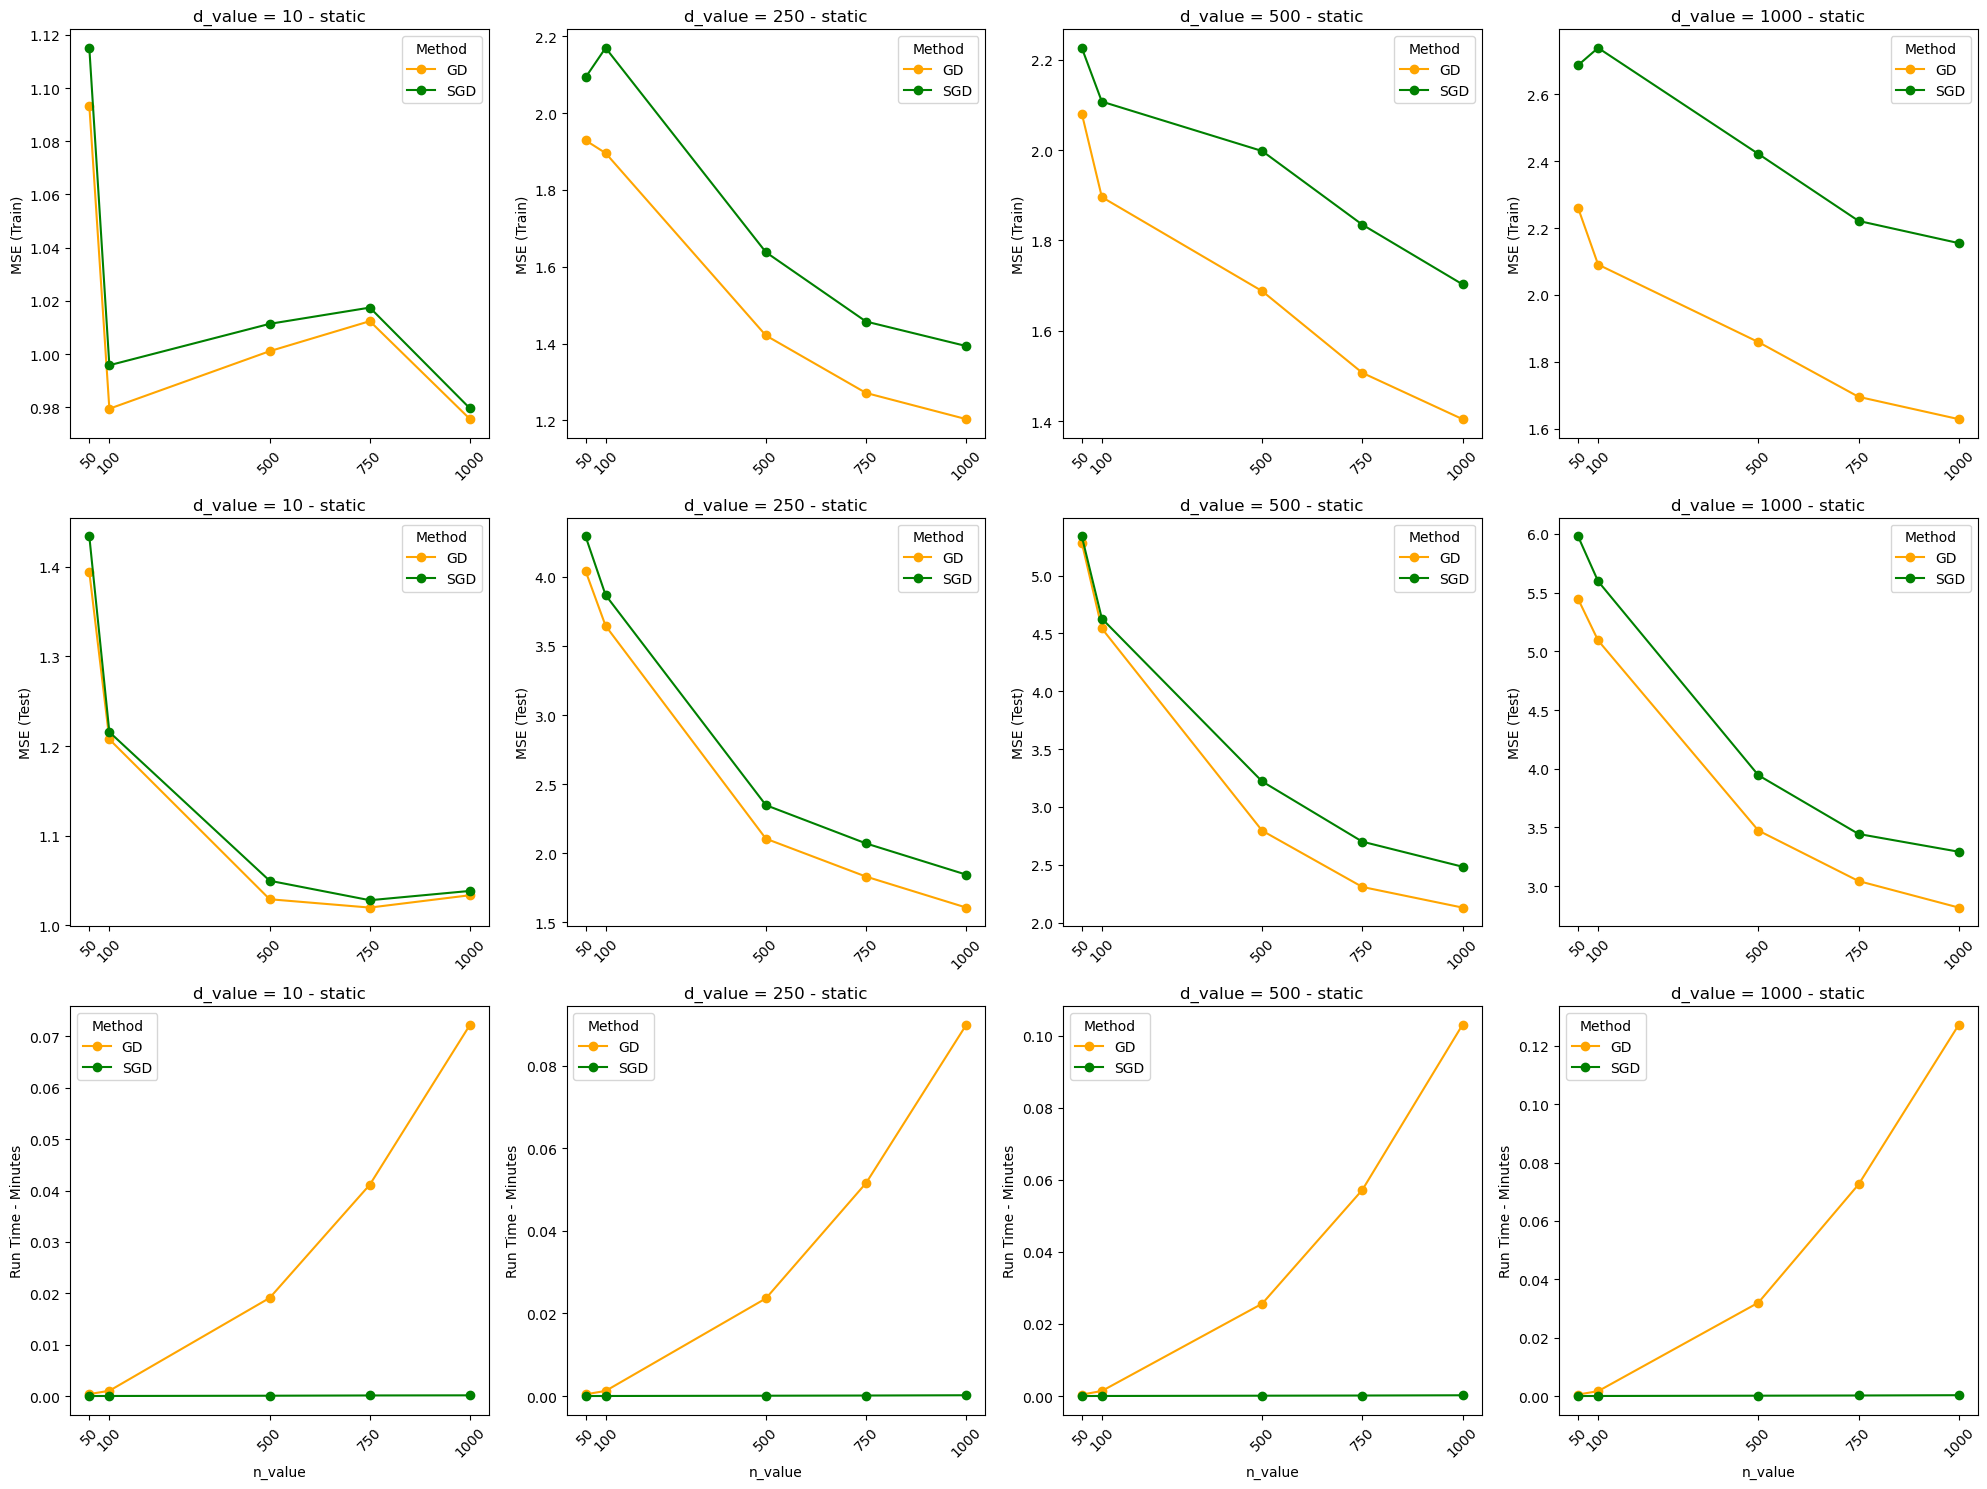

In [16]:
#plot results - only look at GD and SGD

step_size_type = "static"

df_log_ = df_log[df_log['step_size_type']==step_size_type].copy()
df_log_.reset_index(drop = True, inplace = True)

col_avg_values = ['mse_train','mse_test','run_time']
for col in col_avg_values:
    df_log_[col] = df_log_.groupby(by = ['method','n_value','d_value'])[col].transform('mean')

df_log_.drop_duplicates(subset = ['method','n_value','d_value'], inplace = True)
methods = ['GD', 'SGD']
# df_log_['mse_train'] = np.log10(df_log_['mse_train'])
# df_log_['mse_test'] = np.log10(df_log_['mse_test'])
df = df_log_.copy()

# Creating the plot with adjustments for clear visibility of 'n_value'
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
for i, metric in enumerate(['mse_train', 'mse_test', 'run_time']):
    for j, d_val in enumerate(d_values):
        ax = axes[i, j]
        for method in methods:
            if method == "GD":
                subset = df[(df['method'] == method) & (df['d_value'] == d_val)]
                ax.plot(subset['n_value'].to_numpy(), subset[metric].to_numpy(), color='orange', marker='o', linestyle='-', label=method)
            elif method == "SGD":
                subset = df[(df['method'] == method) & (df['d_value'] == d_val)]
                ax.plot(subset['n_value'].to_numpy(), subset[metric].to_numpy(), color='green', marker='o', linestyle='-', label=method)
            else:
                subset = df[(df['method'] == method) & (df['d_value'] == d_val)]
                ax.plot(subset['n_value'].to_numpy(), subset[metric].to_numpy(), color='blue', marker='o', linestyle='-', label=method)
        
        ax.set_title(f'd_value = {d_val} - {step_size_type}')
        if i == 0:
            ax.set_ylabel('MSE (Train)')
        elif i == 1:
            ax.set_ylabel('MSE (Test)')
        else:
            ax.set_ylabel('Run Time - Minutes')
        ax.legend(title='Method')
        ax.set_xticks(subset['n_value'])
        ax.tick_params(axis='x', rotation=45)

for ax in axes[-1, :]:
    ax.set_xlabel('n_value')

plt.tight_layout()
plt.show()


Here we have the same graph presentation as before but without OLS as we saw that OLS parameters did not approximate the training data well or predict test data well. We see that the difference of MSE between GD and SGD increases as dimension and sample size increases which we would expect. GD represents the data better which we would expect as it uses all of the sample data to update the parameters yet SGD doesn't perform much worse (by MSE) and has a faster run time. We do see that both models perform worse on the testing data so a regularization technique would benefit these model creations to prevent overfitting to the training data.

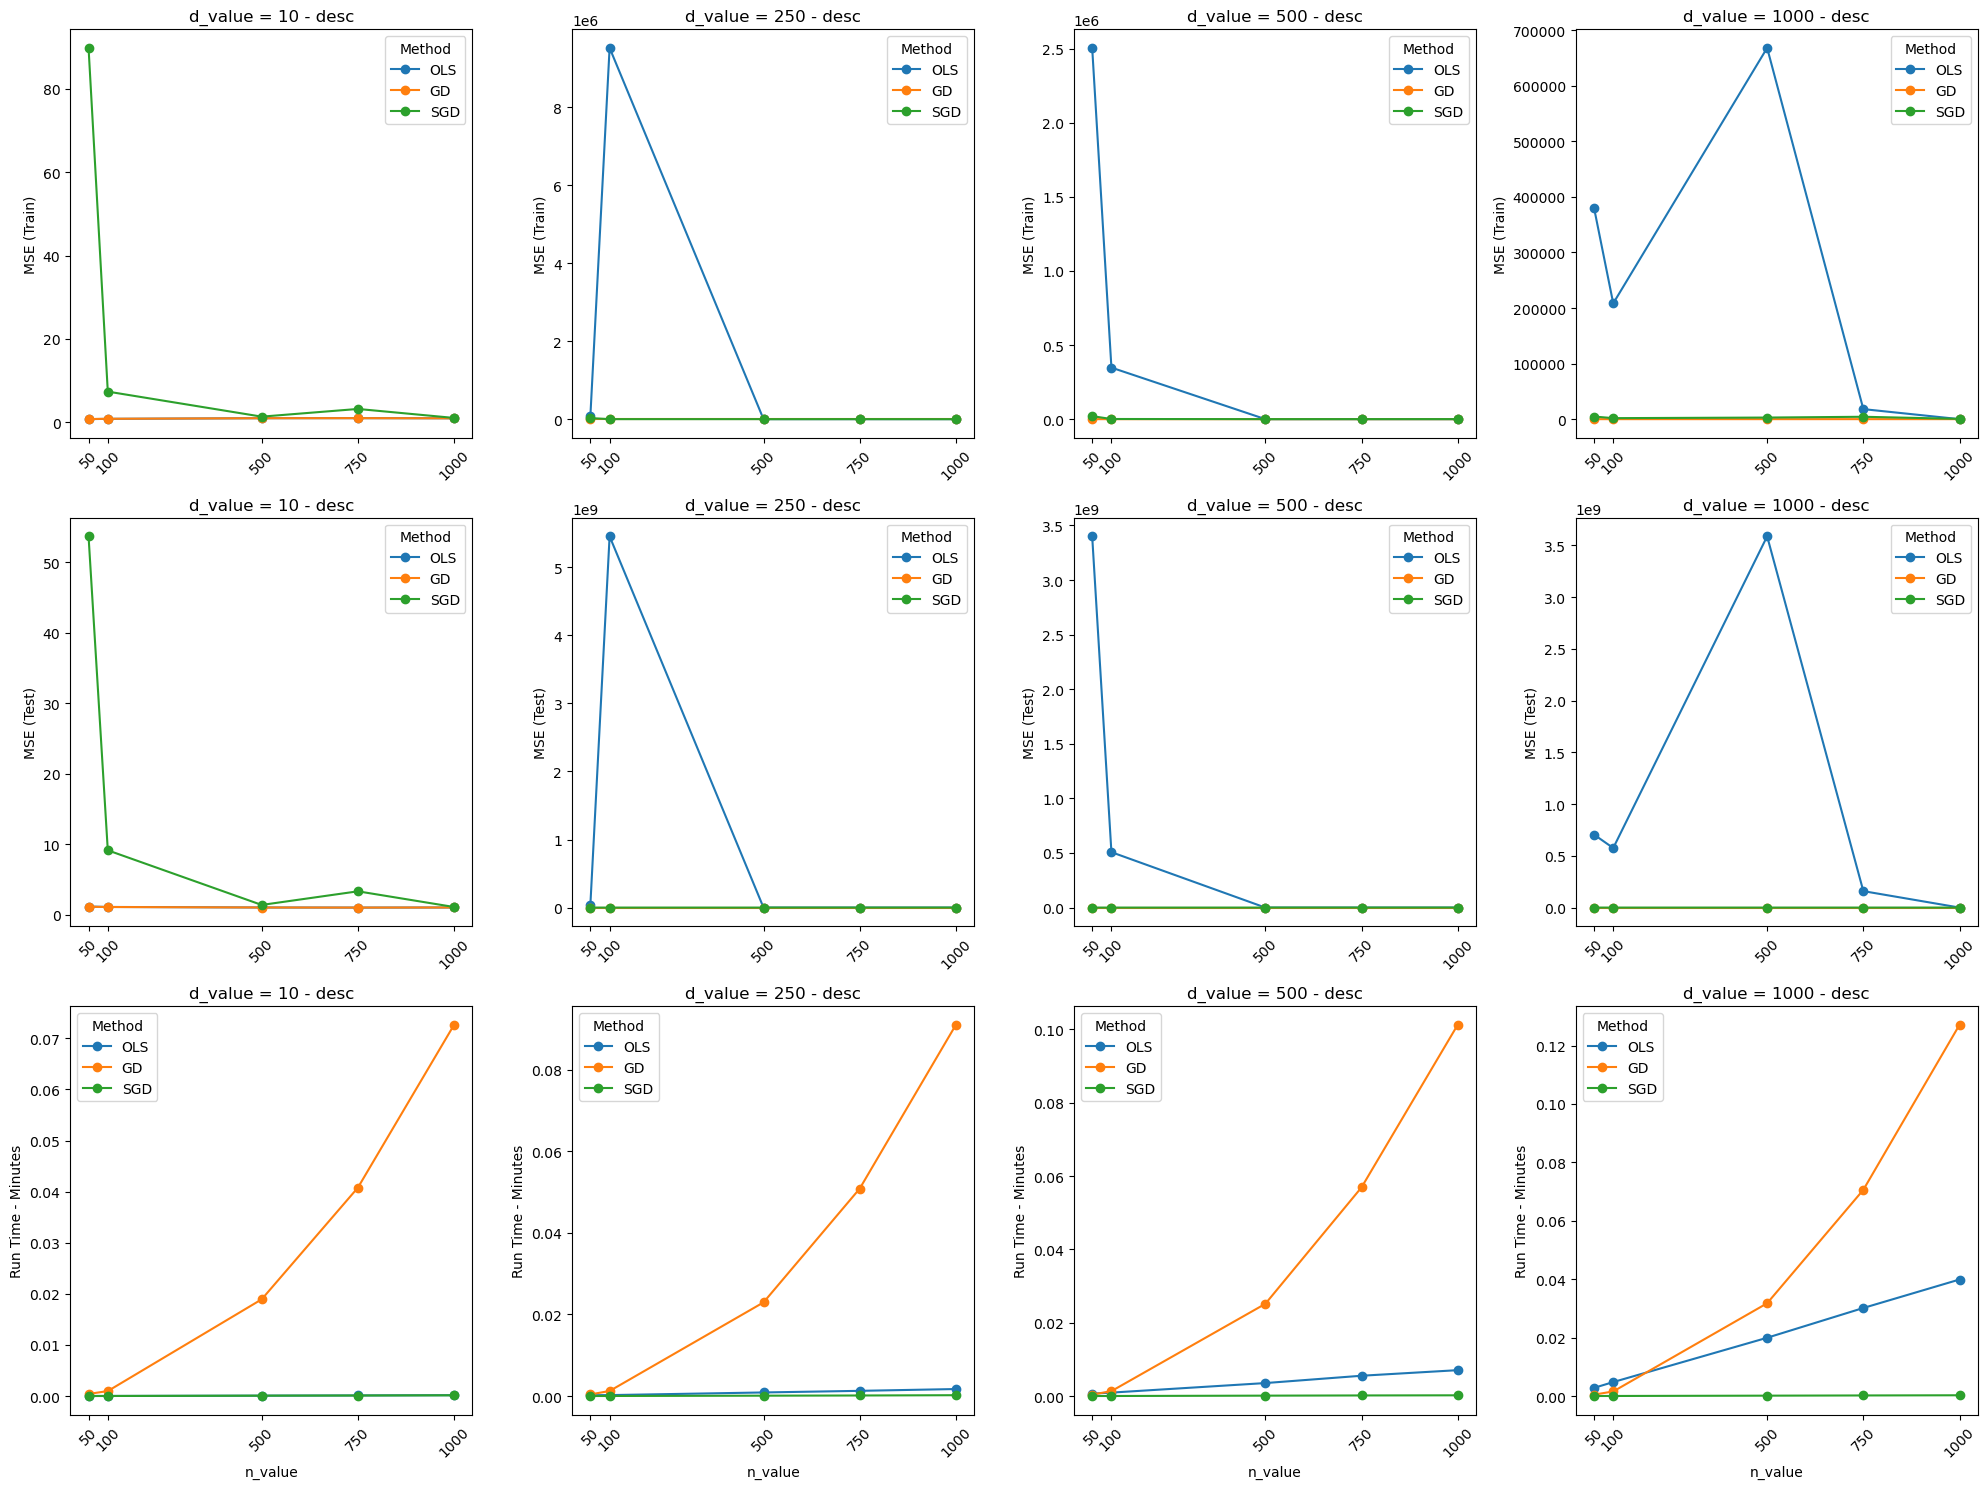

In [18]:
#plot results

step_size_type = "desc"

df_log_ = df_log[df_log['step_size_type']==step_size_type].copy()
df_log_.reset_index(drop = True, inplace = True)

col_avg_values = ['mse_train','mse_test','run_time']
for col in col_avg_values:
    df_log_[col] = df_log_.groupby(by = ['method','n_value','d_value'])[col].transform('mean')

df_log_.drop_duplicates(subset = ['method','n_value','d_value'], inplace = True)
methods = ['OLS', 'GD', 'SGD']
# df_log_['mse_train'] = np.log10(df_log_['mse_train'])
# df_log_['mse_test'] = np.log10(df_log_['mse_test'])
df = df_log_.copy()

# Creating the plot with adjustments for clear visibility of 'n_value'
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
for i, metric in enumerate(['mse_train', 'mse_test', 'run_time']):
    for j, d_val in enumerate(d_values):
        ax = axes[i, j]
        for method in methods:
            subset = df[(df['method'] == method) & (df['d_value'] == d_val)]
            ax.plot(subset['n_value'].to_numpy(), subset[metric].to_numpy(), marker='o', linestyle='-', label=method)
        
        ax.set_title(f'd_value = {d_val} - {step_size_type}')
        if i == 0:
            ax.set_ylabel('MSE (Train)')
        elif i == 1:
            ax.set_ylabel('MSE (Test)')
        else:
            ax.set_ylabel('Run Time - Minutes')
        ax.legend(title='Method')
        ax.set_xticks(subset['n_value'])
        ax.tick_params(axis='x', rotation=45)

for ax in axes[-1, :]:
    ax.set_xlabel('n_value')

plt.tight_layout()
plt.show()

Again, in the above presentation of the graphs, the dimension of the sample population increases from left to right starting with dimension 10 growing in size to dimension 1000. The first row of graphs pertains to the training MSE, the second row pertains to the testing MSE and the last row pertains to the algorithm run time. Each of these graphs is assess by the sample population size of n (n_value.)

The GD and SGD of these graphs pertain to the dynamic learning rate of 1/sqrt(t) for epoch t of the parameter training.

Similar to before, OLS performs much worse on the training and test data and we will further analyze GD and SGD with a dynamic learning rate below.

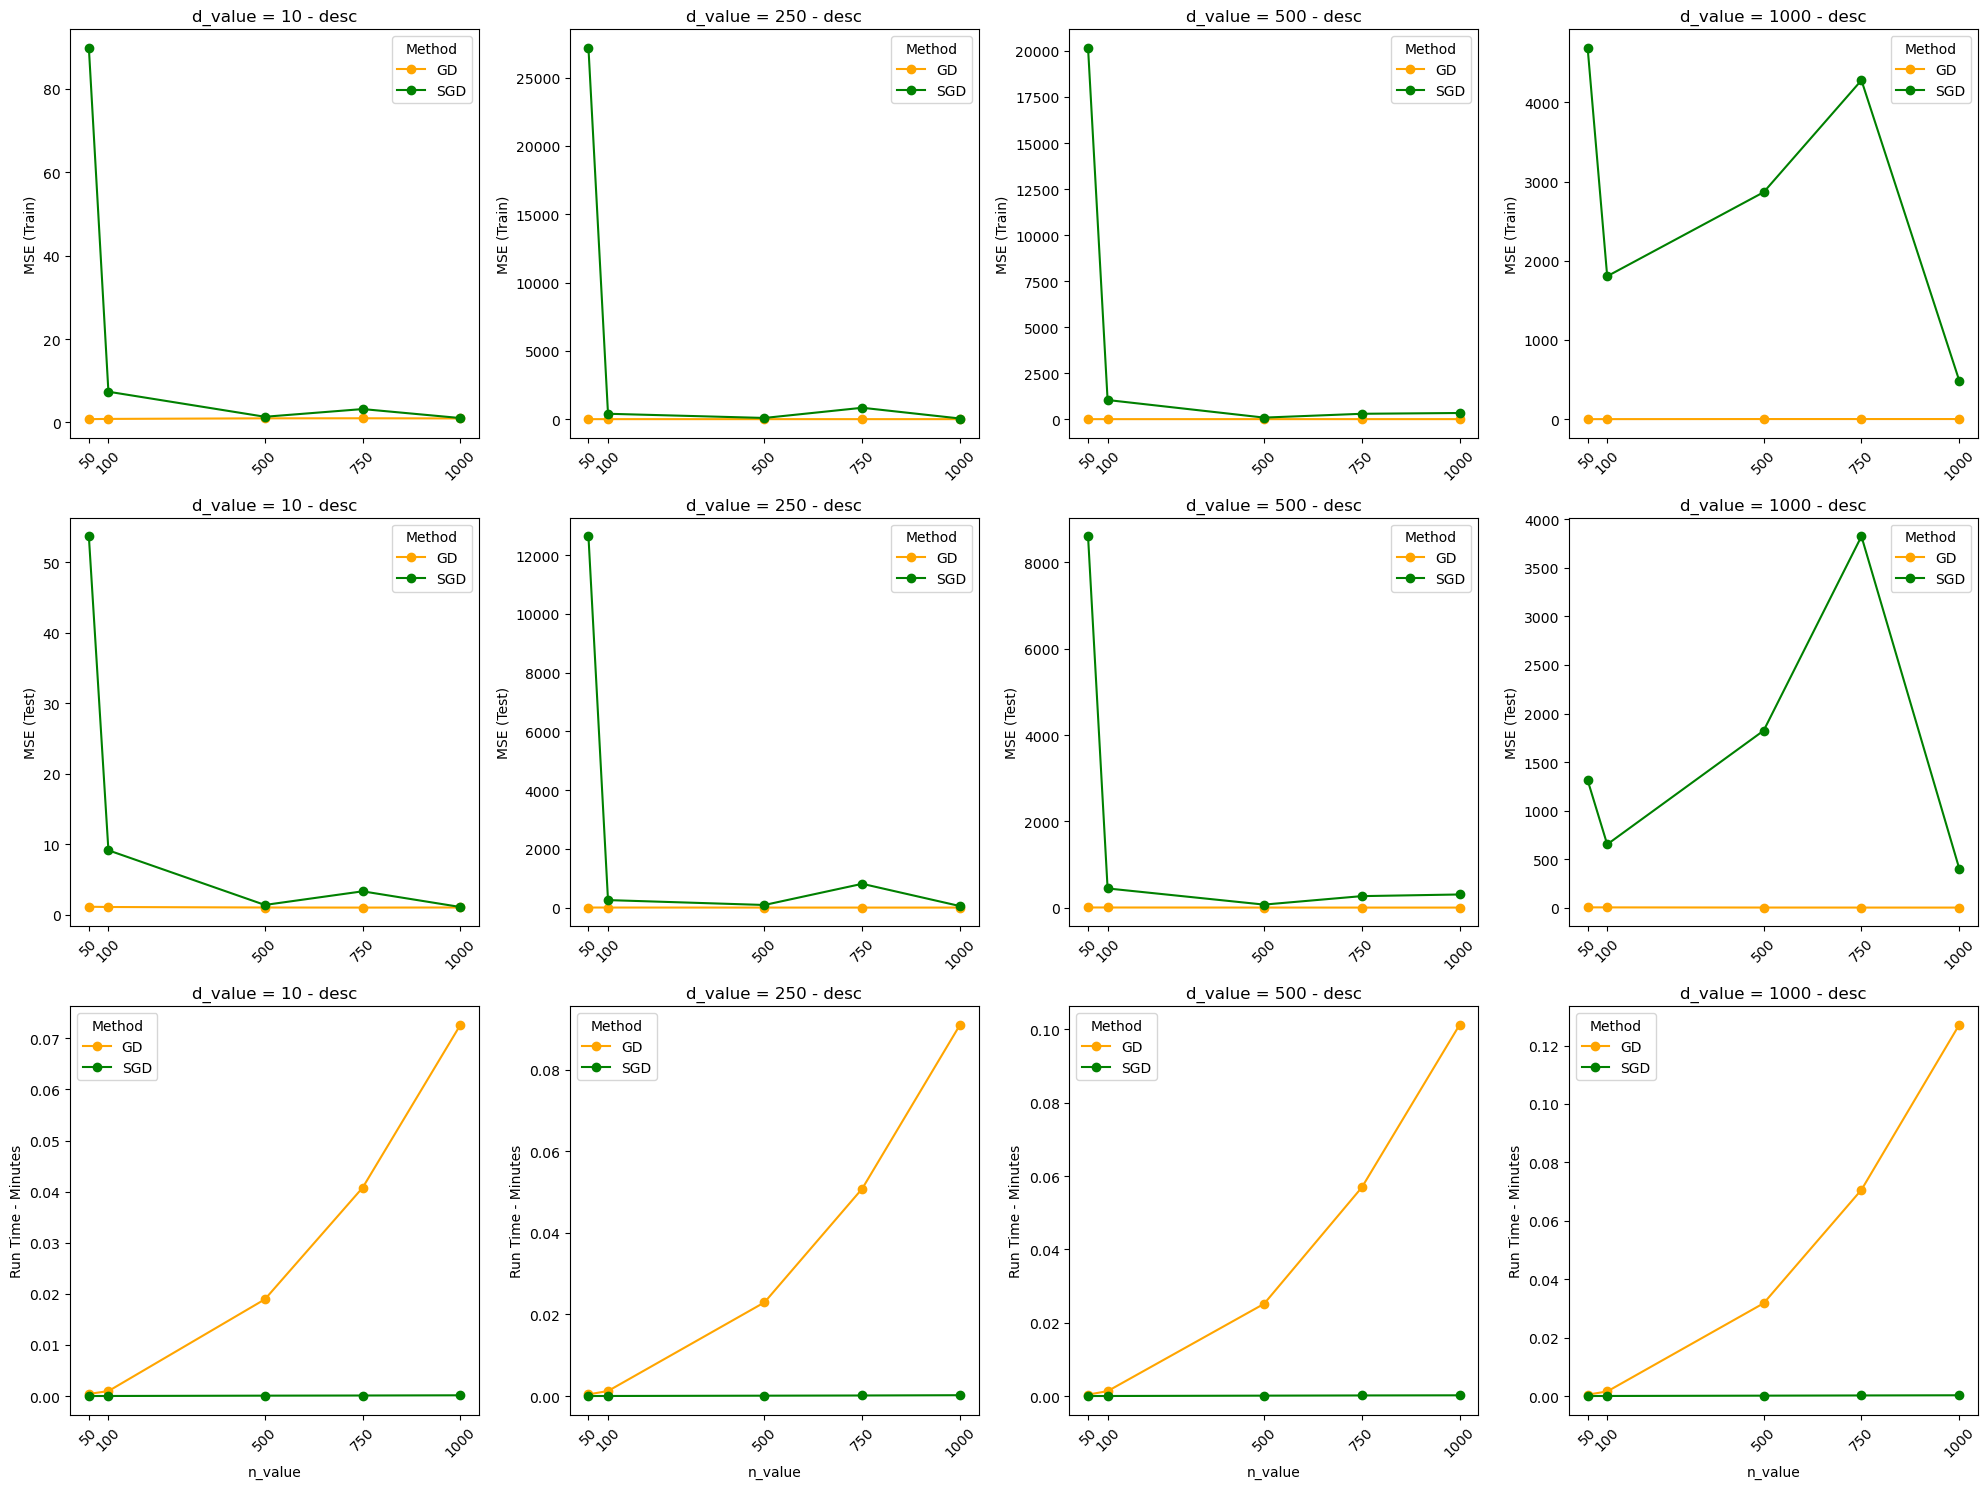

In [19]:
#plot results - only look at GD and SGD

step_size_type = "desc"

df_log_ = df_log[df_log['step_size_type']==step_size_type].copy()
df_log_.reset_index(drop = True, inplace = True)

col_avg_values = ['mse_train','mse_test','run_time']
for col in col_avg_values:
    df_log_[col] = df_log_.groupby(by = ['method','n_value','d_value'])[col].transform('mean')

df_log_.drop_duplicates(subset = ['method','n_value','d_value'], inplace = True)
methods = ['GD', 'SGD']
# df_log_['mse_train'] = np.log10(df_log_['mse_train'])
# df_log_['mse_test'] = np.log10(df_log_['mse_test'])
df = df_log_.copy()

# Creating the plot with adjustments for clear visibility of 'n_value'
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
for i, metric in enumerate(['mse_train', 'mse_test', 'run_time']):
    for j, d_val in enumerate(d_values):
        ax = axes[i, j]
        for method in methods:
            if method == "GD":
                subset = df[(df['method'] == method) & (df['d_value'] == d_val)]
                ax.plot(subset['n_value'].to_numpy(), subset[metric].to_numpy(), color='orange', marker='o', linestyle='-', label=method)
            elif method == "SGD":
                subset = df[(df['method'] == method) & (df['d_value'] == d_val)]
                ax.plot(subset['n_value'].to_numpy(), subset[metric].to_numpy(), color='green', marker='o', linestyle='-', label=method)
            else:
                subset = df[(df['method'] == method) & (df['d_value'] == d_val)]
                ax.plot(subset['n_value'].to_numpy(), subset[metric].to_numpy(), color='blue', marker='o', linestyle='-', label=method)
        
        ax.set_title(f'd_value = {d_val} - {step_size_type}')
        if i == 0:
            ax.set_ylabel('MSE (Train)')
        elif i == 1:
            ax.set_ylabel('MSE (Test)')
        else:
            ax.set_ylabel('Run Time - Minutes')
        ax.legend(title='Method')
        ax.set_xticks(subset['n_value'])
        ax.tick_params(axis='x', rotation=45)

for ax in axes[-1, :]:
    ax.set_xlabel('n_value')

plt.tight_layout()
plt.show()

With the dynamic learning rate we're seeing that the GD and SGD perform much worse. Previously with the GD and SGD with a static learning rate, the MSE was always below 3 with respect to the training data yet here we see the SGD is a lot higher whereas the GD appears to be consistent. I'd interpret this as SGD parameters do not converge to a solution as quickly as our learning rate whereas GD converges to the parameters more quickly so the learning rate decreasing over time doesn't change the parameters converging as much. Similarly for the testing data we previously saw the max MSE for GD and SGD was around 6 whereas its much higher here for SGD. Again we see that the GD run time is much higher than SGD which we would expect as GD utilizes all of the training data for each parameter update step.